# NIRCam subarray photometry

Analyzing JWST NIRCam calibration data of a standard star observed in various subarrays to ensure photometry is robust.

JWST CAL 4452  
https://www.stsci.edu/jwst/science-execution/program-information?id=4452  
https://www.stsci.edu/cgi-bin/get-visit-status?observatory=JWST&id=4452  


All imaging but including subarrays defined for other modes:  
 1 - 36: imaging  
37 – 46: grism  
47 – 56: coronagraphy  
https://docs.google.com/spreadsheets/d/1OV8J8RZ0hMWo-u0saz6Wjs_RH9lqB7D4m0Pcbk00AXI




In [1]:
import numpy as np
import os
from glob import glob
from copy import deepcopy
home = os.path.expanduser("~")
import warnings  # to suppress warnings from photutils

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter, MultipleLocator
%matplotlib inline
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt') # https://matplotlib.org/tutorials/introductory/customizing.html
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
import astropy
import astropy.io
from astropy.io import fits
import astropy.io.ascii
import astropy.wcs as wcs
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm, SqrtStretch, LogStretch, hist, LinearStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from astropy.visualization import make_lupton_rgb
from astropy.stats import SigmaClip, sigma_clipped_stats
from astropy.convolution import convolve, Gaussian2DKernel, interpolate_replace_nans

In [4]:
import photutils
print('photutils', photutils.__version__)
from photutils.aperture import SkyCircularAperture, CircularAperture, CircularAnnulus, ApertureStats  # https://photutils.readthedocs.io/en/stable/aperture.html
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import detect_sources, SourceCatalog

photutils 1.9.0


In [5]:
def hypotn(x, axis=0):
    return np.sqrt(np.sum(x**2, axis=axis))

In [6]:
import fnmatch

def select_jwst_files(filename_list, program='?????', observation='???', visit='???', group='??', prime_parallel='?', activity='??', 
                      exposure='?????', detector='*', filetype='*', extension='fits'):
    #if type(observation) in (int, float):
    #filename_list = [os.path.basename(infile) for infile in filename_list]
    observation = '%03d' % observation
    search_string = 'jw' + program + observation + visit \
        + '_' + group + prime_parallel + activity + '_' + exposure \
        + '_' + detector + '_' + filetype + '.' + extension

    return fnmatch.filter(filename_list, search_string)

In [7]:
datadir = 'images'
allfiles = glob(os.path.join(datadir, '*'))
allfiles = [os.path.basename(infile) for infile in allfiles]
allfiles = np.sort(allfiles).tolist()
#allfiles

In [8]:
infiles = select_jwst_files(allfiles, observation=9, filetype='cal')
num_exposures = len(infiles)
infiles

['jw04452009001_02102_00001_nrcb1_cal.fits',
 'jw04452009001_02102_00002_nrcb1_cal.fits',
 'jw04452009001_02102_00003_nrcb1_cal.fits',
 'jw04452009001_02102_00004_nrcb1_cal.fits']

### Photutils photometry

https://photutils.readthedocs.io/en/latest/segmentation.html

Don't subtract background - might subtract starlight! - just plan on subtracting annulus

In [9]:
nsigma  = 10  # Don't do 5; you'll pick up junk
npixels = 10
r_phot_pix = 10  # large enough to avoid possible issues with IPC, etc. (advice via Martha from Kevin for NIRISS)
#r_phot_pix = 2.5  # optimal photometry radius – makes a big difference for SNR

### 1/f noise smoothing (optional)

simple method by Dan Coe

In [10]:
def smooth_1overf_correction(data, row_kernel_length=99, column_kernel_length=9):
    # horizontal striping: y-axis row medians
    kernel = np.ones(row_kernel_length) / float(row_kernel_length)
    ymean, ymedian, ystd = sigma_clipped_stats(data, sigma=3, maxiters=10, axis=1)
    ymedian_conv = convolve(ymedian, kernel, boundary='extend')
    row_corrected_data = data + ymedian_conv[:,np.newaxis] - ymedian[:,np.newaxis]
    
    # vertical striping: x-axis column medians
    kernel = np.ones(column_kernel_length) / float(column_kernel_length)
    xmean, xmedian, xstd = sigma_clipped_stats(row_corrected_data, sigma=3, maxiters=10, axis=0)
    xmedian_conv = convolve(xmedian, kernel, boundary='extend')
    corrected_data = row_corrected_data + xmedian_conv[np.newaxis,:] - xmedian[np.newaxis,:]

    return corrected_data

# Measure photometry

In [11]:
# Measure photometry fluxes ...

#firstobs = 37
#detector = 'a1'
#location = detector.upper()+'_SUBGRISM64'
#subarrays = 'SUBGRISM64 SUBGRISM128 SUBGRISM256 FULL'.split()

#measure_photometry(37, 'a1', '_SUBGRISM64', 'SUBGRISM64')

def measure_photometry(observation, detector, location_subarray, subarray, verbose=True, outfile='photometry_4452.txt', show_images=True,
                      mask_bad_pixels=True, smooth1overf=False):
    location = detector.upper() + location_subarray

    if show_images:
        n = num_exposures
        nrows = 1
        ncolumns = np.ceil(n / nrows).astype(int)
        
        fig_width  = 12
        fig_height = fig_width * nrows / ncolumns
        
        fig, ax = plt.subplots(nrows, ncolumns, figsize=(fig_width,fig_height), layout="constrained", sharex=True, sharey=True)
        ax = ax.flatten()
        
        #cmap = matplotlib.cm.get_cmap()
        cmap = matplotlib.colormaps['viridis']
        cmap.set_bad(color='red')

    
    #print('Observation', observation)
    infiles = select_jwst_files(allfiles, observation=observation, filetype='cal')
    fluxes = []
    fluxerrs = []
    for iexposure in np.arange(num_exposures):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            # Load data
            exposure = iexposure + 1
            infile = infiles[iexposure]
            infile = os.path.join(datadir, infile)
            #print(exposure, infile)
            data = fits.getdata(infile)
            hdu = fits.open(infile)
            photmjsr = hdu[1].header['PHOTMJSR']
            data /= photmjsr # put back into counts / s to mitigate uncertainty from PHOTMJSR
            error = fits.open(infile)['ERR'].data
            
            # Mask & fill bad pixels
            if mask_bad_pixels:
                kernel = Gaussian2DKernel(x_stddev=1)  # 9x9 array w/ x & y stddev = 1
                data = interpolate_replace_nans(data, kernel)               
                error = interpolate_replace_nans(error, kernel)
                #print('mask bad pixels')
                #print('mask bad error pixels')

            if smooth1overf:
                data = smooth_1overf_correction(data)
            
            imwcs = wcs.WCS(hdu[1].header, hdu)
            ny, nx = data.shape
            # image_pixel_scale = np.abs(hdu[0].header['CD1_1']) * 3600
            image_pixel_scale = wcs.utils.proj_plane_pixel_scales(imwcs)[0] 
            image_pixel_scale *= imwcs.wcs.cunit[0].to('arcsec')
            outline = '%d x %d pixels' % (ny, nx)
            outline += ' = %g" x %g"' % (ny * image_pixel_scale, nx * image_pixel_scale)
            outline += ' (%.3f" / pixel)' % image_pixel_scale
            #print(outline)

            # Detect sources
            bkg_estimator = MedianBackground()
            background_map = Background2D(data, (5, 5), filter_size=(3, 3), bkg_estimator=bkg_estimator)
            # Don't subtract background: might subtract starlight! - just plan on subtracting annulus
            #data -= bkg.background  # subtract the background
            #bkg.background_rms
            threshold = nsigma * background_map.background_rms_median
            segment_map = detect_sources(data, threshold, npixels=npixels)
            if type(segment_map) == type(None):
                print('ERROR: No objects found!')
                raise

            cat = SourceCatalog(data, segment_map, wcs=imwcs, error=error)
            source_table = cat.to_table()
            i = np.argmax(source_table['segment_flux'])
            x = source_table[i]['xcentroid']
            y = source_table[i]['ycentroid']
            positions = np.array([x, y]).T
            #annulus_apertures = CircularAnnulus(positions, r_in=15, r_out=18)
            annulus_apertures = CircularAnnulus(positions, r_in=20, r_out=30)
            sigclip = SigmaClip(sigma=3.0, maxiters=10)
            bkg_stats = ApertureStats(data, annulus_apertures, sigma_clip=sigclip)

            # Photometry
            aperture = CircularAperture((x, y), r_phot_pix)
            #aperture.plot(color=(0,1,0), lw=2)
            aperture_stats = ApertureStats(data, aperture, error=error)
            flux = aperture_stats.sum
            fluxerr = aperture_stats.sum_err
            total_bkg = bkg_stats.median * aperture_stats.sum_aper_area.value
            flux -= total_bkg
            #flux = flux / max_flux
            fluxes.append(flux)
            fluxerrs.append(fluxerr)
            
            outline = '%3d  %d  %4d  %3d  % 5d  %5.3f  %s' % (observation, exposure, flux, fluxerr, total_bkg, photmjsr, os.path.basename(infile))
            if verbose:
                print(outline)
            if outfile:
                fout = open(outfile, 'a')
                fout.write(outline+'\n')
                fout.close()
            
            #print('%3d  %d  %4d  %3d  % 5d  %5.3f' % (observation, exposure, flux, fluxerr, total_bkg, photmjsr), os.path.basename(infile))
            #print('%d  %4d  %3d  % 4d  %5.3f' % (exposure, flux, fluxerr, total_bkg, photmjsr), os.path.basename(infile))

        if show_images:    
            norm = simple_norm(data, 'sqrt', percent=99.9)
            im = ax[iexposure].imshow(data, norm=norm, origin='lower', interpolation='nearest', cmap=cmap)
            ap_patches  = aperture.plot(         ax[iexposure], color='white', lw=2, label='Photometry aperture')
            ann_patches = annulus_apertures.plot(ax[iexposure], color='red',   lw=2, label='Background annulus')
            #if len(xx) > 1:
            #    all_ap_patches = all_apertures.plot( ax[iexposure], color='white', lw=2, label='Photometry aperture')
                
    if show_images:
        outfile = 'obs%02d.png' % observation
        outfile = os.path.join(plots_dir, outfile)
        plt.savefig(outfile)
        
    return fluxes, fluxerrs
    
#fluxes, fluxerrs = measure_photometry(5, 'b5', '_SUB160', 'SUB160', smooth1overf=True)
#measure_photometry(5, 'b5', '_SUB160', 'SUB160 SUB320 SUB640 FULL')

In [12]:
def measure_photometry_set(firstobs, detector, location_subarray, subarrays, verbose=True, outfile='photometry_4452.txt', show_images=True,
                          mask_bad_pixels=True, smooth1overf=False, show_summary_plot=True):
    subarrays = subarrays.split()
    nobs = len(subarrays)
    obsnums = firstobs + np.arange(nobs)
    location = detector.upper() + location_subarray
    obsnums, nobs, location
    
    all_fluxes = []
    all_fluxerrs = []
    for iobs, observation in enumerate(obsnums):
        #print('Observation', observation)
        subarray = subarrays[iobs]
        fluxes, fluxerrs = measure_photometry(observation, detector, location_subarray, subarray, 
                                              mask_bad_pixels=mask_bad_pixels, smooth1overf=smooth1overf)

        all_fluxes.append(fluxes)
        all_fluxerrs.append(fluxerrs)

    if show_summary_plot:
        plot_photometry_set(all_fluxes, all_fluxerrs, subarrays, location)
    
    return all_fluxes, all_fluxerrs, location
    
#measure_photometry_set(5, 'b5', '_SUB160', 'SUB160 SUB320 SUB640 FULL')

In [13]:
def plot_photometry_set(all_fluxes, all_fluxerrs, subarrays, location, save_plot=True):
    all_fluxes = np.array(all_fluxes)
    all_fluxerrs = np.array(all_fluxerrs)
    nobs, nexposures = all_fluxes.shape
    #fluxerr_sum = hypotn(all_fluxerrs, 1)
    #avg_flux = np.mean(all_fluxes)  # average of all
    avg_flux = np.mean(all_fluxes[-1])  # average of last 4: the full-frame fluxes
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))#, sharex=True, sharey=True)
    colors = mpl_colors
    dx = 0.05 * np.arange(nexposures)
    dx = dx - np.mean(dx)
    for i in range(nexposures):
        xx = np.arange(nobs) + dx[i]
        iexposure = i + 1
        label = 'Dither %d' % iexposure
        #plt.plot(xx, all_fluxes[:,i], '-o', label=label, color=colors[i])
        plt.errorbar(xx, all_fluxes[:,i]/avg_flux, all_fluxerrs[:,i]/avg_flux, 
                     marker='o', label=label, mfc=colors[i], alpha=0.5)
    
    xx = np.arange(nobs)
    flux_sum    = np.mean(all_fluxes, axis=1) / avg_flux
    fluxerr_sum = hypotn(all_fluxerrs, axis=1) / avg_flux / 4.
    #plt.plot(xx, flux_sum, 'k-D', ms=10, label='Average', zorder=100)
    plt.errorbar(xx, flux_sum, fluxerr_sum, c='k', mfc='k', mec='k', marker='D', ms=10, label='Average', zorder=100)
    
    plt.legend()
    xtx = np.arange(nobs)
    xts = subarrays
    plt.xticks(xtx, xts)
    plt.ylim(0.85, 1.15)
    plt.semilogy()
    plt.ylabel('Normalized Count Rate', fontsize=18)
    #plt.grid()
    plt.axhline(1, c='0.50', alpha=0.5, lw=1, zorder=-10)
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    #ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    ax.yaxis.set_minor_formatter(ticker.FormatStrFormatter("%g"))
    ax.margins(x=0.1)
    
    plt.title('Location: ' + location)

    if save_plot:
        outfile = 'phot_%s.png' % location
        outfile = os.path.join(plots_dir, outfile)
        plt.savefig(outfile)

In [14]:
plots_dir = '../plots/'  # output plots
os.makedirs(plots_dir, exist_ok=True)

# Run photometry

  1  1  5629  208     55  4.760  jw04452001001_02102_00001_nrcb1_cal.fits
  1  2  5646  221    272  4.760  jw04452001001_02102_00002_nrcb1_cal.fits
  1  3  5692  197    -50  4.760  jw04452001001_02102_00003_nrcb1_cal.fits
  1  4  5753  214    698  4.760  jw04452001001_02102_00004_nrcb1_cal.fits
  2  1  5859  434  -2340  4.760  jw04452002001_02102_00001_nrcb1_cal.fits
  2  2  5532  440   -886  4.760  jw04452002001_02102_00002_nrcb1_cal.fits
  2  3  5929  451   1310  4.760  jw04452002001_02102_00003_nrcb1_cal.fits
  2  4  5600  439    527  4.760  jw04452002001_02102_00004_nrcb1_cal.fits
  3  1  5621  174   -176  4.760  jw04452003001_02102_00001_nrcb1_cal.fits
  3  2  5652  176   -175  4.760  jw04452003001_02102_00002_nrcb1_cal.fits
  3  3  5725  184    185  4.760  jw04452003001_02102_00003_nrcb1_cal.fits
  3  4  5749  177     -9  4.760  jw04452003001_02102_00004_nrcb1_cal.fits
  4  1  5726   61     47  4.760  jw04452004001_02101_00001_nrcb1_cal.fits
  4  2  5735   62     13  4.760  jw044

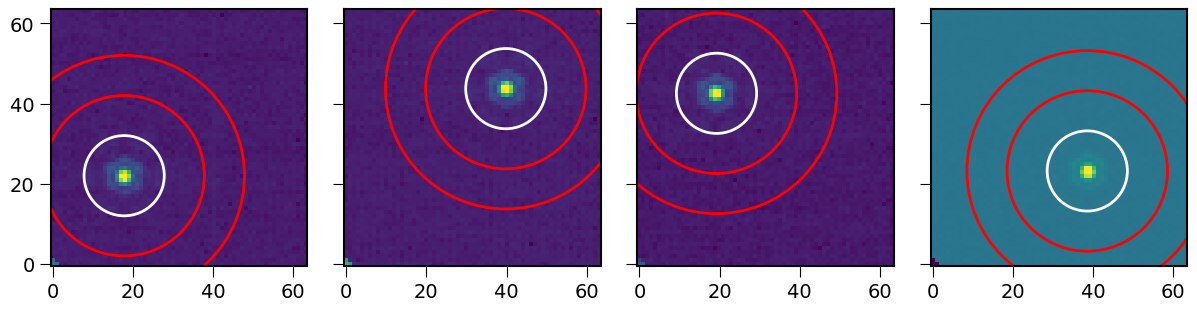

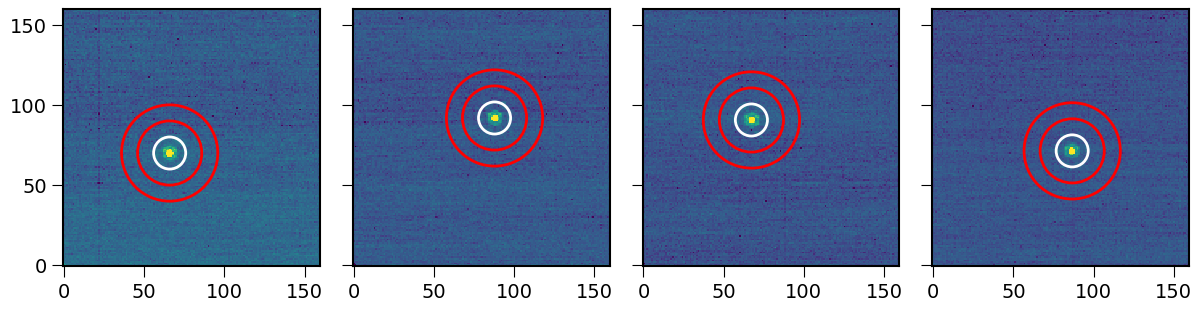

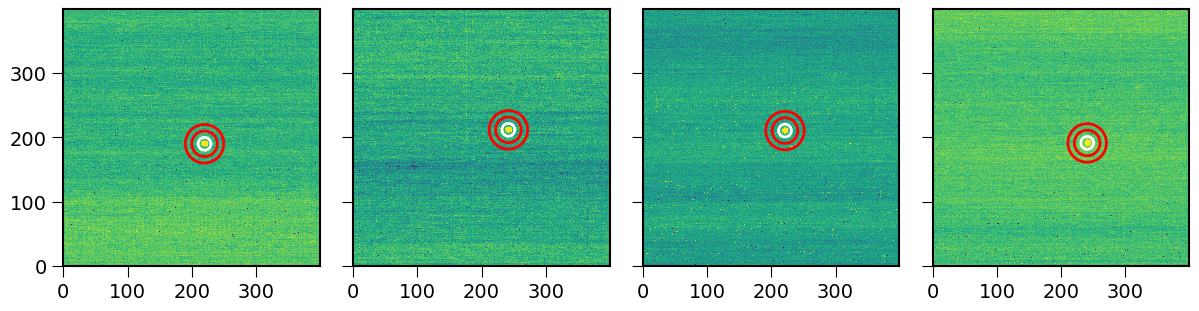

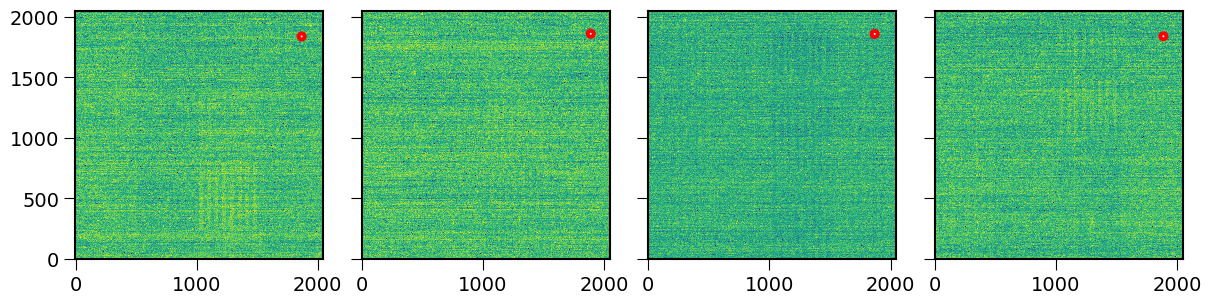

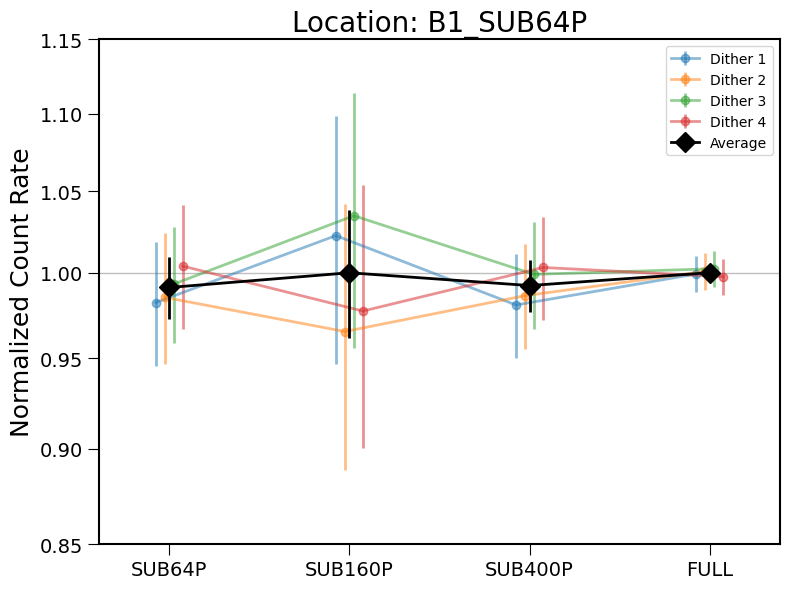

In [15]:
all_fluxes, all_fluxerrs, location = measure_photometry_set( 1, 'b1', '_SUB64P', 'SUB64P SUB160P SUB400P FULL')

In [ ]:
all_fluxes, all_fluxerrs, location = measure_photometry_set(5, 'b5', '_SUB160', 'SUB160 SUB320 SUB640 FULL')

In [ ]:
all_fluxes, all_fluxerrs, location = measure_photometry_set(9, 'b1', '_SUB160', 'SUB160 SUB320 SUB640 FULL')

In [ ]:
all_fluxes, all_fluxerrs, location = measure_photometry_set(13, 'b2', '_SUB160', 'SUB160 SUB320 SUB640 FULL')

In [ ]:
all_fluxes, all_fluxerrs, location = measure_photometry_set(17, 'b3', '_SUB160', 'SUB160 SUB320 SUB640 FULL')

In [ ]:
all_fluxes, all_fluxerrs, location = measure_photometry_set(21, 'b4', '_SUB160', 'SUB160 SUB320 SUB640 FULL')

In [ ]:
all_fluxes, all_fluxerrs, location = measure_photometry_set(25, 'a3', '_SUB64P', 'SUB64P FULL')

In [ ]:
all_fluxes, all_fluxerrs, location = measure_photometry_set(27, 'a5', '_SUB160', 'SUB160 FULL')

In [ ]:
all_fluxes, all_fluxerrs, location = measure_photometry_set(29, 'a1', '_SUB160', 'SUB160 FULL')

In [ ]:
all_fluxes, all_fluxerrs, location = measure_photometry_set(31, 'a2', '_SUB160', 'SUB160 FULL')

In [ ]:
all_fluxes, all_fluxerrs, location = measure_photometry_set(33, 'a3', '_SUB160', 'SUB160 FULL')

In [ ]:
all_fluxes, all_fluxerrs, location = measure_photometry_set(35, 'a4', '_SUB160', 'SUB160 FULL')

In [ ]:
all_fluxes, all_fluxerrs, location = measure_photometry_set(37, 'a1', '_SUBGRISM64', 'SUBGRISM64 SUBGRISM128 SUBGRISM256 FULL')

In [ ]:
all_fluxes, all_fluxerrs, location = measure_photometry_set(41, 'a3', '_SUBGRISM64', 'SUBGRISM64 SUBGRISM128 SUBGRISM256 FULL')

In [ ]:
all_fluxes, all_fluxerrs, location = measure_photometry_set(45, 'a5', '_SUBGRISM64', 'SUBGRISM64 FULL')